# Semi Supervised Learning - BERT

I maually labelled some of the transactions in the data with categories that I obtained from the council's budget. The plan was to then use these labels to train the algorithm to label the unlabelled data.

In [56]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#for downloading BERT
# pip install sentence_transformers
from sentence_transformers import SentenceTransformer

#for finding most similar text vectors
from sklearn.metrics.pairwise import cosine_similarity

#regular expressoin toolkit
import re

#NLP toolkits
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

#for plotting transaction categories later
plt.style.use('ggplot')
import seaborn as sns
import matplotlib.ticker as ticker # for formatting major units on x-y axis
# colours for seaborn.
color_pal = sns.color_palette()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/samuelspeller/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# # import the semi-labelled data and write to a pkl file

# df = pd.read_excel('./spending_data/bristol_spending_data_final_semi_labeled.xlsx')

# # set non numeric values to n/a with errors=coerce
# df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')

# # convert the date to a datetime object
# df['Pay Date']= pd.to_datetime(df['Pay Date'], format='%d/%m/%Y')

# # check the df
# print(df.info())

# # Write to pickle pickle file
# with open('./pkl_data/bristol_spending_data_semi_labelled.pkl', 'wb') as pickle_file:
#     pickle.dump(df, pickle_file)

In [3]:
# import data
# Load the semi-labelled dataset   
with open('./pkl_data/bristol_spending_data_semi_labelled.pkl', 'rb') as pickle_file:
    df = pickle.load(pickle_file)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022713 entries, 0 to 1022712
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Supplier       1022713 non-null  object        
 1   Amount         1022712 non-null  float64       
 2   Pay Date       1022713 non-null  datetime64[ns]
 3   Description 1  1022704 non-null  object        
 4   Description 2  1018731 non-null  object        
 5   Description 3  834026 non-null   object        
 6   label          45276 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 54.6+ MB


## Split into labelled and unlabelled data

In [20]:
# lets create a dictionary containing the labels with descriptions
labels = {1:'Education, Learning and Skills Improvement',
          2:'Safeguarding vulnerable adults and children',
          3:'Social care and support for adults including the elderly',
          4:'Support for voluntary groups',
          5:'Public Health',
          6:'pupil premium (education)',
          7:'Museums and Culture',
          8:'Property',
          9:'Community Services Parks and open spaces',
          10:'Housing and Landlord Services',
          11:'early years education',
          12:'SEN',
          13:'Other'
          }

In [5]:
# we want to train on the labelled data so lets pull all the transactions with labels

# the dataframe has some 0 values and some na. Lets convert all the 0 to na
df['label'] = df['label'].replace(0, np.nan)

# filter rows where the label is NaN, e.g. not labelled
labelled_df = df.loc[df['label'].notna()]
unlabelled_df = df.loc[df['label'].isna()]


print(labelled_df.head())
print(unlabelled_df.head())

print(f'\n\nthe number of labelled transactions: {len(labelled_df)}')
print(f'\n\nthe number of unlabelled transactions: {len(unlabelled_df)}')

                                      Supplier   Amount   Pay Date  \
0                                 MUSO LIMITED    600.0 2013-03-28   
1                        ARNOLFINI GALLERY LTD   5000.0 2013-03-25   
2                             SHOW OF STRENGTH   8000.0 2013-03-25   
3                          THE TOBACCO FACTORY  10000.0 2013-03-25   
4  BRISTOL INTERNATIONAL JAZZ & BLUES FESTIVAL   2500.0 2013-03-18   

                Description 1               Description 2  \
0                FEES PAYABLE  "ARTS, EVENTS & FESTIVALS"   
1  PAYMENTS TO OTHER AGENCIES  "ARTS, EVENTS & FESTIVALS"   
2  PAYMENTS TO OTHER AGENCIES  "ARTS, EVENTS & FESTIVALS"   
3  PAYMENTS TO OTHER AGENCIES  "ARTS, EVENTS & FESTIVALS"   
4              GRANTS PAYABLE  "ARTS, EVENTS & FESTIVALS"   

                Description 3  label  
0            ARTS & FESTIVALS    7.0  
1                   ARNOLFINI    7.0  
2            SHOW OF STRENGTH    7.0  
3  TOBACCO FACTORY ARTS TRUST    7.0  
4          NEIGHB

## combine descriptions

lets combine the supplier name and the descriptions so we can tokenize and train on all of them at the same time

In [6]:
# create a new column containing all the text data
# make sure there is a space inbetween the different column text data.
# ignore a value if it is NaN or 'REDACTED' as we don't want the model to train on these.

columns_to_combine = ['Supplier', 'Description 1', 'Description 2', 'Description 3' ]

labelled_df['text_data'] = labelled_df[columns_to_combine].apply(lambda x: ' '.join(y for y in x.dropna().astype(str) if 'REDACTED' not in y), axis=1)

unlabelled_df['text_data'] = unlabelled_df[columns_to_combine].apply(lambda x: ' '.join(y for y in x.dropna().astype(str) if 'REDACTED' not in y), axis=1)

/var/folders/t7/n_c5tq1n0h985pbhlhf2w0c80000gn/T/ipykernel_61773/914057943.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labelled_df['text_data'] = labelled_df[columns_to_combine].apply(lambda x: ' '.join(y for y in x.dropna().astype(str) if 'REDACTED' not in y), axis=1)
/var/folders/t7/n_c5tq1n0h985pbhlhf2w0c80000gn/T/ipykernel_61773/914057943.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabelled_df['text_data'] = unlabelled_df[columns_to_combine].apply(lambda x: ' '.join(y for y in x.dropna

In [7]:
labelled_df.head()

,Supplier,Amount,Pay Date,Description 1,Description 2,Description 3,label,text_data
0,MUSO LIMITED,600.0,2013-03-28,FEES PAYABLE,"""ARTS, EVENTS & FESTIVALS""",ARTS & FESTIVALS,7.0,"MUSO LIMITED FEES PAYABLE ""ARTS, EVENTS & FEST..."
1,ARNOLFINI GALLERY LTD,5000.0,2013-03-25,PAYMENTS TO OTHER AGENCIES,"""ARTS, EVENTS & FESTIVALS""",ARNOLFINI,7.0,ARNOLFINI GALLERY LTD PAYMENTS TO OTHER AGENCI...
2,SHOW OF STRENGTH,8000.0,2013-03-25,PAYMENTS TO OTHER AGENCIES,"""ARTS, EVENTS & FESTIVALS""",SHOW OF STRENGTH,7.0,"SHOW OF STRENGTH PAYMENTS TO OTHER AGENCIES ""A..."
3,THE TOBACCO FACTORY,10000.0,2013-03-25,PAYMENTS TO OTHER AGENCIES,"""ARTS, EVENTS & FESTIVALS""",TOBACCO FACTORY ARTS TRUST,7.0,THE TOBACCO FACTORY PAYMENTS TO OTHER AGENCIES...
4,BRISTOL INTERNATIONAL JAZZ & BLUES FESTIVAL,2500.0,2013-03-18,GRANTS PAYABLE,"""ARTS, EVENTS & FESTIVALS""",NEIGHBOURHOOD ARTS,7.0,BRISTOL INTERNATIONAL JAZZ & BLUES FESTIVAL GR...


## Create word embeddings for labeled data
Download and then use the pre-trained BERT model to do this.

In [8]:
def clean_text_BERT(text):
    '''
    A function to clean and tokenize text so it is ready to be inputted into BERT
    '''

    # Convert words to lower case.
    text = text.lower()

    # Remove special characters and numbers. This also removes the dates 
    # which are not important in classifying expenses
    text = re.sub(r'[^\w\s]|https?://\S+|www\.\S+|https?:/\S+|[^\x00-\x7F]+|\d+', '', str(text).strip())
  
    # Tokenise 
    text_list = word_tokenize(text)
    result = ' '.join(text_list)
    return result

In [9]:
# clean our text data
text_raw = labelled_df['text_data']
text_BERT = text_raw.apply(lambda x: clean_text_BERT(x))

In [10]:
# an example of the text data before and after cleaning
print(text_raw[2000])
print(text_BERT[2000])


St George Health Centre Services - Supplies and Services to service users 03:NHS Health Checks  
st george health centre services supplies and services to service users nhs health checks


In [11]:
# # This may take some time to download and run.
# # depending on the size of the input.
# # I have saved the output using the cell below so it can be loaded quickly.

# model = SentenceTransformer('paraphrase-mpnet-base-v2') 
# bert_input = text_BERT.tolist()
# embeddings = model.encode(bert_input, show_progress_bar = True)
# embedding_BERT = np.array(embeddings)

In [12]:
# # save these embeddings to a numpy file
# np.save('./pkl_data/labelled_data_embedding.npy', embedding_BERT)


In [13]:
# load the embeddings from the pkl file
embedding_BERT = np.load('./pkl_data/labelled_data_embedding.npy', allow_pickle = True)

embedding_BERT

array([[-0.1147997 ,  0.00622684, -0.06120515, ..., -0.01737143,
         0.16032901, -0.01618893],
       [-0.05237475,  0.2965644 , -0.03495542, ..., -0.00776623,
         0.12089074,  0.03460617],
       [-0.13074368,  0.17108506, -0.05069165, ...,  0.01171169,
         0.10542176, -0.04691478],
       ...,
       [-0.10476775,  0.19025211,  0.00164859, ..., -0.12478687,
        -0.25964585, -0.03215555],
       [-0.10476775,  0.19025211,  0.00164859, ..., -0.12478687,
        -0.25964585, -0.03215555],
       [-0.10476775,  0.19025211,  0.00164859, ..., -0.12478687,
        -0.25964585, -0.03215555]], dtype=float32)

In [14]:
# # have a look at the word embeddings

# df_embedding_bert = pd.DataFrame(embeddings)
# df_embedding_bert.head()

## Create word embeddings for unlabelled data

In [22]:
# first create a test sample (as it takes a long time to compute this)
# get a random sample of n rows from the dataframe
n = 20000
test_unlabelled_df = unlabelled_df.sample(n)

# Load texts
text_test_raw = test_unlabelled_df['text_data']

# Apply data cleaning function as for training data
text_test_BERT = text_test_raw.apply(lambda x: clean_text_BERT(x))


# Apply BERT embedding
bert_input_test = text_test_BERT.tolist()
model = SentenceTransformer('paraphrase-mpnet-base-v2') 
embeddings_test = model.encode(bert_input_test, show_progress_bar = True)
embedding_BERT_test = np.array(embeddings_test)

df_embedding_bert_test = pd.DataFrame(embeddings_test)

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

## Pair unseen data with the most similar training data

In [23]:
# Find the most similar word embedding with unseen data in the training data

similarity_new_data = cosine_similarity(embedding_BERT_test, embedding_BERT)
similarity_df = pd.DataFrame(similarity_new_data)

# Returns index for most similar embedding
# See first column of the output dataframe below
index_similarity = similarity_df.idxmax(axis = 1)

print(index_similarity)

0        23929
1        42773
2        27155
3        43606
4        12481
         ...  
19995     7217
19996     8739
19997    30209
19998     8604
19999     7734
Length: 20000, dtype: int64


In [24]:
# Return dataframe for most similar embedding/transactions in training dataframe
data_inspect = labelled_df.iloc[index_similarity, :].reset_index(drop = True)

unseen_verbatim = text_test_raw.reset_index(drop = True)
matched_verbatim = data_inspect['text_data']
label = data_inspect['label']

d_output = {
            'unseen_transaction': unseen_verbatim,
            'matched_transaction': matched_verbatim, 
            'matched_class': label
            
            }

d_output_df = pd.DataFrame.from_dict(d_output)
d_output_df



,unseen_transaction,matched_transaction,matched_class
0,"OTIS LIMITED CAP - CONVERSION, RENOVATION & IM...",R82 UK Ltd Equipment - Purchase EY Block: Addi...,11.0
1,Your Lifestyle TPP - Community Outreach MI Nor...,Your Lifestyle TPP - Community Outreach Prepar...,3.0
2,Maples Community Care Ltd TPP - Accommodation ...,Maples TPP - Accommodation Based Support MI No...,5.0
3,RANDSTAD EDUCATION LTD AGENCY STAFF COSTS PRIM...,RANDSTAD EDUCATION LTD AGENCY STAFF COSTS PRIM...,1.0
4,Lorne Stewart PLC R&M - Departmental planned (...,Ian Williams Ltd R&M - Departmental planned (e...,8.0
...,...,...,...
19995,University Of Bath Services - Fees and Charges...,University Of The West Of England (Tuition Fee...,5.0
19996,Carlisle Staffing PLC T/A Guidant Global Agenc...,Carlisle Staffing PLC T/A Guidant Agency Staff...,3.0
19997,BRUNELCARE H S C ONLY - NURSING CARE OLDER PEO...,BRUNELCARE H S C ONLY - NURSING CARE OLDER PEO...,3.0
19998,Derwent FM Computing - Repair and Maint Applic...,Bristol It Company Computing - Repair and Main...,13.0


## create a new dataframe where all the data is labelled

In [26]:
# copy the labels into the unlabelled_df
model_labelled_df = test_unlabelled_df.copy()
model_labelled_df['label'] = d_output['matched_class'].values
model_labelled_df['label_description'] = model_labelled_df['label'].map(labels)

model_labelled_df

,Supplier,Amount,Pay Date,Description 1,Description 2,Description 3,label,text_data,label_description
795843,OTIS LIMITED,7500.78,2011-11-28,"CAP - CONVERSION, RENOVATION & IMPROVEME",PLANNED PROGRAMME,M&E INVESTMENT IN BLOCKS,11.0,"OTIS LIMITED CAP - CONVERSION, RENOVATION & IM...",early years education
517486,Your Lifestyle,1525.44,2018-11-09,TPP - Community Outreach,MI North A - Learning Disability Support 18-64,,3.0,Your Lifestyle TPP - Community Outreach MI Nor...,Social care and support for adults including t...
182065,Maples Community Care Ltd,638.40,2016-12-09,TPP - Accommodation Based Support,Central/East - Mental Health Support 18-64,NaN,5.0,Maples Community Care Ltd TPP - Accommodation ...,Public Health
830709,RANDSTAD EDUCATION LTD,825.00,2011-01-28,AGENCY STAFF COSTS,PRIMARY - SCHOOL FUNDED,104 BARTON HILL PRIMARY & CHILDREN'S CTR,1.0,RANDSTAD EDUCATION LTD AGENCY STAFF COSTS PRIM...,"Education, Learning and Skills Improvement"
731464,Lorne Stewart PLC,708.75,2023-01-25,R&M - Departmental planned (external),Parking - Sheene Road,,8.0,Lorne Stewart PLC R&M - Departmental planned (...,Property
...,...,...,...,...,...,...,...,...,...
602909,University Of Bath,5500.00,2014-08-01,Services - Fees and Charges,Occupational Health & Counselling,NaN,5.0,University Of Bath Services - Fees and Charges...,Public Health
915867,Carlisle Staffing PLC T/A Guidant Global,629.74,2019-12-09,Agency Staff,School Admissions,,3.0,Carlisle Staffing PLC T/A Guidant Global Agenc...,Social care and support for adults including t...
620050,BRUNELCARE,679.36,2012-08-10,H S C ONLY - NURSING CARE,OLDER PEOPLE,LOCALITY ASSESSMENT TEAM S2,3.0,BRUNELCARE H S C ONLY - NURSING CARE OLDER PEO...,Social care and support for adults including t...
58102,Derwent FM,1500.00,2014-12-01,Computing - Repair and Maint,"Applications S&M, Licensing",NaN,13.0,Derwent FM Computing - Repair and Maint Applic...,Other


In [28]:
# combine the now-labelled and originally labelled data
combined_labelled_df = pd.concat([model_labelled_df, labelled_df], axis=0)

# map the label values to the descriptions in the label dictonary
combined_labelled_df['label_description'] = combined_labelled_df['label'].map(labels)
combined_labelled_df

,Supplier,Amount,Pay Date,Description 1,Description 2,Description 3,label,text_data,label_description
795843,OTIS LIMITED,7500.78,2011-11-28,"CAP - CONVERSION, RENOVATION & IMPROVEME",PLANNED PROGRAMME,M&E INVESTMENT IN BLOCKS,11.0,"OTIS LIMITED CAP - CONVERSION, RENOVATION & IM...",early years education
517486,Your Lifestyle,1525.44,2018-11-09,TPP - Community Outreach,MI North A - Learning Disability Support 18-64,,3.0,Your Lifestyle TPP - Community Outreach MI Nor...,Social care and support for adults including t...
182065,Maples Community Care Ltd,638.40,2016-12-09,TPP - Accommodation Based Support,Central/East - Mental Health Support 18-64,NaN,5.0,Maples Community Care Ltd TPP - Accommodation ...,Public Health
830709,RANDSTAD EDUCATION LTD,825.00,2011-01-28,AGENCY STAFF COSTS,PRIMARY - SCHOOL FUNDED,104 BARTON HILL PRIMARY & CHILDREN'S CTR,1.0,RANDSTAD EDUCATION LTD AGENCY STAFF COSTS PRIM...,"Education, Learning and Skills Improvement"
731464,Lorne Stewart PLC,708.75,2023-01-25,R&M - Departmental planned (external),Parking - Sheene Road,,8.0,Lorne Stewart PLC R&M - Departmental planned (...,Property
...,...,...,...,...,...,...,...,...,...
1001715,BIRCHAM DYSON BELL LLP,14092.00,2011-03-04,CAP - FEES PAYABLE,TRANSPORT PLANNING,STUDIES INTO MAJOR HIGHWAY IMPROVEMENTS,13.0,BIRCHAM DYSON BELL LLP CAP - FEES PAYABLE TRAN...,Other
1001716,STEER DAVIES GLEAVE,15076.08,2011-03-04,CAP - FEES PAYABLE,TRANSPORT PLANNING,STUDIES INTO MAJOR HIGHWAY IMPROVEMENTS,13.0,STEER DAVIES GLEAVE CAP - FEES PAYABLE TRANSPO...,Other
1001717,STEER DAVIES GLEAVE,14698.49,2011-03-04,CAP - FEES PAYABLE,TRANSPORT PLANNING,STUDIES INTO MAJOR HIGHWAY IMPROVEMENTS,13.0,STEER DAVIES GLEAVE CAP - FEES PAYABLE TRANSPO...,Other
1001718,STEER DAVIES GLEAVE,9629.53,2011-03-02,CAP - FEES PAYABLE,TRANSPORT PLANNING,STUDIES INTO MAJOR HIGHWAY IMPROVEMENTS,13.0,STEER DAVIES GLEAVE CAP - FEES PAYABLE TRANSPO...,Other


# label all the data for 2022 and plot it
it takes a lot of compute power to run data through the BERT embedder, so we will run it on all the data for 2022 and investigate that.

## Get the unlabelled data from 2022

In [32]:
# use pandas to grab all the unlabelled data from 2022
unlabelled_2022_df = unlabelled_df[unlabelled_df['Pay Date'].dt.year == 2022]
unlabelled_2022_df.head()

,Supplier,Amount,Pay Date,Description 1,Description 2,Description 3,label,text_data
2781,Bristol Pest Control Ltd,450.00,2022-12-01,Pest Control,100 Temple Street,,NaN,Bristol Pest Control Ltd Pest Control 100 Temp...
2782,School Milk Services Ltd,519.84,2022-10-26,Catering,100 Temple Street,,NaN,School Milk Services Ltd Catering 100 Temple S...
2783,School Milk Services Ltd,517.62,2022-10-03,Catering,100 Temple Street,,NaN,School Milk Services Ltd Catering 100 Temple S...
2784,Initial Washroom Solutions,895.83,2022-09-06,Waste Management,100 Temple Street,,NaN,Initial Washroom Solutions Waste Management 10...
2785,New Delight Enterprises Ltd,950.00,2022-07-21,Services - Fees and Charges,100 Temple Street,,NaN,New Delight Enterprises Ltd Services - Fees an...


## label this data
use the same approach as before

In [33]:
# Load texts
text_raw_2022 = unlabelled_2022_df['text_data']

# Apply data cleaning function as for training data
text_BERT_2022 = text_raw_2022.apply(lambda x: clean_text_BERT(x))


# Apply BERT embedding
bert_input_2022 = text_BERT_2022.tolist()
model = SentenceTransformer('paraphrase-mpnet-base-v2') 
embeddings_2022 = model.encode(bert_input_2022, show_progress_bar = True)
embedding_BERT_2022 = np.array(embeddings_2022)

df_embedding_bert_2022 = pd.DataFrame(embeddings_2022)

Batches:   0%|          | 0/2037 [00:00<?, ?it/s]

In [34]:
# Find the most similar word embedding with unseen data in the training data

similarity_2022 = cosine_similarity(embedding_BERT_2022, embedding_BERT)
similarity_2022_df = pd.DataFrame(similarity_2022)

# Returns index for most similar embedding
# See first column of the output dataframe below
index_similarity_2022 = similarity_2022_df.idxmax(axis = 1)

print(index_similarity_2022)

0         8599
1        30065
2        30065
3         8606
4        27141
         ...  
65178    16426
65179    16426
65180    24091
65181     6854
65182     7011
Length: 65183, dtype: int64


In [37]:
# Return dataframe for most similar embedding/transactions in training dataframe
data_inspect_2022 = labelled_df.iloc[index_similarity_2022, :].reset_index(drop = True)

unseen_verbatim_2022 = text_raw_2022.reset_index(drop = True)
matched_verbatim_2022 = data_inspect_2022['text_data']
label_2022 = data_inspect_2022['label']

d_output_2022 = {
            'unseen_transaction': unseen_verbatim_2022,
            'matched_transaction': matched_verbatim_2022, 
            'matched_class': label_2022
            
            }

d_output_2022_df = pd.DataFrame.from_dict(d_output_2022)
d_output_2022_df



,unseen_transaction,matched_transaction,matched_class
0,Bristol Pest Control Ltd Pest Control 100 Temp...,Ecolab Ltd Pest Control Bottleyard,13.0
1,School Milk Services Ltd Catering 100 Temple S...,SCHOOL MILK SERVICES LTD CATERING OLDER PEOPLE...,3.0
2,School Milk Services Ltd Catering 100 Temple S...,SCHOOL MILK SERVICES LTD CATERING OLDER PEOPLE...,3.0
3,Initial Washroom Solutions Waste Management 10...,Initial Washroom Solutions Contract Cleaning B...,13.0
4,New Delight Enterprises Ltd Services - Fees an...,Drawn In Bristol Services - Fees and Charges M...,13.0
...,...,...,...
65178,Underley Furnishings Ltd t/a Furnished Homes M...,Young London Today Living Allowance External S...,3.0
65179,Underley Furnishings Ltd t/a Furnished Homes M...,Young London Today Living Allowance External S...,3.0
65180,Arcadis LLP Services - Fees and Charges Zero E...,LAVENDON ACCESS SERVICES (UK) LTD DIRECT TRANS...,13.0
65181,Bridges for Communities TPP - Payments to volu...,Social Access TPP - Payments to voluntary grou...,4.0


In [38]:
# copy the labels into the unlabelled_2022_df
model_labelled_2022_df = unlabelled_2022_df.copy()
model_labelled_2022_df['label'] = d_output_2022['matched_class'].values
model_labelled_2022_df['label_description'] = model_labelled_2022_df['label'].map(labels)

model_labelled_2022_df

,Supplier,Amount,Pay Date,Description 1,Description 2,Description 3,label,text_data,label_description
2781,Bristol Pest Control Ltd,450.00,2022-12-01,Pest Control,100 Temple Street,,13.0,Bristol Pest Control Ltd Pest Control 100 Temp...,Other
2782,School Milk Services Ltd,519.84,2022-10-26,Catering,100 Temple Street,,3.0,School Milk Services Ltd Catering 100 Temple S...,Social care and support for adults including t...
2783,School Milk Services Ltd,517.62,2022-10-03,Catering,100 Temple Street,,3.0,School Milk Services Ltd Catering 100 Temple S...,Social care and support for adults including t...
2784,Initial Washroom Solutions,895.83,2022-09-06,Waste Management,100 Temple Street,,13.0,Initial Washroom Solutions Waste Management 10...,Other
2785,New Delight Enterprises Ltd,950.00,2022-07-21,Services - Fees and Charges,100 Temple Street,,13.0,New Delight Enterprises Ltd Services - Fees an...,Other
...,...,...,...,...,...,...,...,...,...
1018375,Underley Furnishings Ltd t/a Furnished Homes,629.96,2022-08-04,Materials,Youth Housing -Expenditure,,3.0,Underley Furnishings Ltd t/a Furnished Homes M...,Social care and support for adults including t...
1018376,Underley Furnishings Ltd t/a Furnished Homes,499.98,2022-07-22,Materials,Youth Housing -Expenditure,,3.0,Underley Furnishings Ltd t/a Furnished Homes M...,Social care and support for adults including t...
1018730,Arcadis LLP,8945.75,2022-12-30,Services - Fees and Charges,Zero Emissions Transport City (ZETC),,13.0,Arcadis LLP Services - Fees and Charges Zero E...,Other
1018731,Bridges for Communities,2500.00,2022-05-31,TPP - Payments to voluntary groups,NaN,,4.0,Bridges for Communities TPP - Payments to volu...,Support for voluntary groups


In [40]:
# get all the pre-labelled data from 2022
labelled_2022_df = labelled_df[labelled_df['Pay Date'].dt.year == 2022]
labelled_2022_df.tail()

,Supplier,Amount,Pay Date,Description 1,Description 2,Description 3,label,text_data
332528,Sunshine Pre School,615.0,2022-02-21,TPP - Grants,EY Block: Disability Access Fund,,11.0,Sunshine Pre School TPP - Grants EY Block: Dis...
332529,Upper Horfield Childrens Centre,615.0,2022-02-21,TPP - Grants,EY Block: Disability Access Fund,,11.0,Upper Horfield Childrens Centre TPP - Grants E...
332530,Brentry & Henbury Childrens Centre,1845.0,2022-02-21,TPP - Grants,EY Block: Disability Access Fund,,11.0,Brentry & Henbury Childrens Centre TPP - Grant...
332531,Badocks Wood Childrens Centre,1845.0,2022-02-21,TPP - Grants,EY Block: Disability Access Fund,,11.0,Badocks Wood Childrens Centre TPP - Grants EY ...
332532,Charlton Nursery Ltd,615.0,2022-02-21,TPP - Grants,EY Block: Disability Access Fund,,11.0,Charlton Nursery Ltd TPP - Grants EY Block: Di...


In [64]:
# combine the now-labelled and originally labelled data
combined_labelled_2022_df = pd.concat([model_labelled_2022_df, labelled_2022_df], axis=0)

# map the label values to the descriptions in the label dictonary
combined_labelled_2022_df['label_description'] = combined_labelled_2022_df['label'].map(labels)
combined_labelled_2022_df.head(100)

,Supplier,Amount,Pay Date,Description 1,Description 2,Description 3,label,text_data,label_description
2781,Bristol Pest Control Ltd,450.00,2022-12-01,Pest Control,100 Temple Street,,13.0,Bristol Pest Control Ltd Pest Control 100 Temp...,Other
2782,School Milk Services Ltd,519.84,2022-10-26,Catering,100 Temple Street,,3.0,School Milk Services Ltd Catering 100 Temple S...,Social care and support for adults including t...
2783,School Milk Services Ltd,517.62,2022-10-03,Catering,100 Temple Street,,3.0,School Milk Services Ltd Catering 100 Temple S...,Social care and support for adults including t...
2784,Initial Washroom Solutions,895.83,2022-09-06,Waste Management,100 Temple Street,,13.0,Initial Washroom Solutions Waste Management 10...,Other
2785,New Delight Enterprises Ltd,950.00,2022-07-21,Services - Fees and Charges,100 Temple Street,,13.0,New Delight Enterprises Ltd Services - Fees an...,Other
...,...,...,...,...,...,...,...,...,...
39136,Carlisle Staffing PLC T/A Guidant Global,535.20,2022-12-30,Agency Staff,ABS Unit A,,3.0,Carlisle Staffing PLC T/A Guidant Global Agenc...,Social care and support for adults including t...
39137,Carlisle Staffing PLC T/A Guidant Global,596.81,2022-12-30,Agency Staff,ABS Unit A,,3.0,Carlisle Staffing PLC T/A Guidant Global Agenc...,Social care and support for adults including t...
39138,Carlisle Staffing PLC T/A Guidant Global,596.81,2022-12-30,Agency Staff,ABS Unit A,,3.0,Carlisle Staffing PLC T/A Guidant Global Agenc...,Social care and support for adults including t...
39139,Carlisle Staffing PLC T/A Guidant Global,1169.43,2022-12-30,Agency Staff,ABS Unit A,,3.0,Carlisle Staffing PLC T/A Guidant Global Agenc...,Social care and support for adults including t...


## Plot the spending in terms of category
plot the 2022 data in terms of type of transaction

In [67]:
# convert to amount to £million
combined_labelled_2022_df['Amount_million'] = combined_labelled_2022_df['Amount']/1000000

# sum the transactions by label
grouped = combined_labelled_2022_df.groupby('label_description')['Amount_million'].sum()

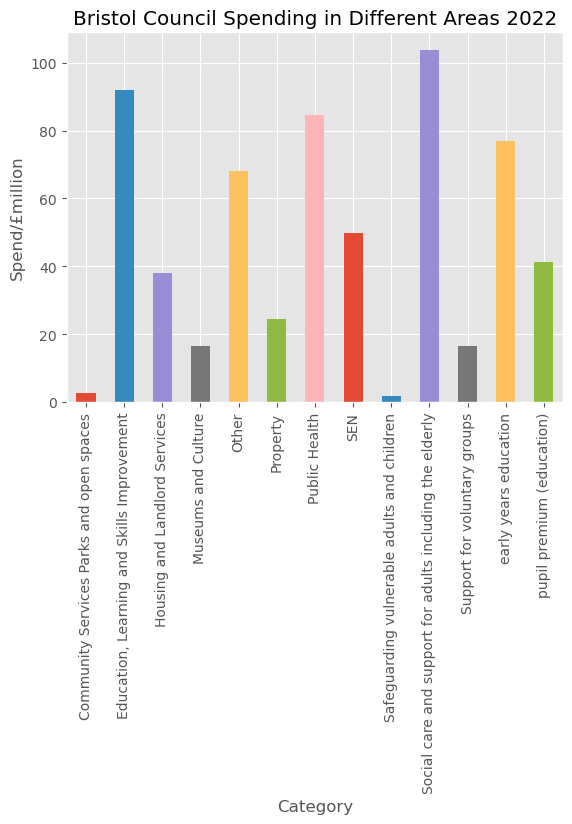

In [69]:
# Plot the grouped data
grouped.plot(kind='bar', stacked=True, color=color_pal)
plt.title('Bristol Council Spending in Different Areas 2022')
plt.xlabel('Category')
plt.ylabel('Spend/£million')
plt.show()

# Next Steps

* save the word embeddings so we don't need to compute them every time. DONE!
* train a random set of unlabelled data. DONE!
* label all the spending for one finacial year DONE!
* test the model on the labelled data using train test split.
* train all the data